In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import csv


from typing import List, Tuple, Sequence, Set, FrozenSet, Dict, Iterator, Iterable, Generator, Any, Optional, Mapping

In [2]:
num_classes = 10
epochs = 50
latent_dim = 128

In [3]:
with open('../digits_train_prepr_revised.csv', newline='') as f: # Load dataset
    reader = csv.reader(f)
    train_x = [ [int(g) for g in image ] for image in list(reader) ] # Convert text to integers

In [4]:
with open('../digits_test_prepr_revised.csv', newline='') as f: # Load dataset
    reader = csv.reader(f)
    test_x = [ [float(g) for g in image ] for image in list(reader) ] # Convert text to integers

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
model3 = keras.models.load_model("../recognizer/model3")
model5 = keras.models.load_model("../recognizer/model5")
model7 = keras.models.load_model("../recognizer/model7")

model3PCA = keras.models.load_model("../recognizer PCA/model3")
model5PCA = keras.models.load_model("../recognizer PCA/model5")
model7PCA = keras.models.load_model("../recognizer PCA/model7")

discriminator = keras.models.load_model("../ACGAN/discriminator")
generator = keras.models.load_model("../ACGAN/generator")

In [7]:
def ensemblepredict(xset, mod3, mod5, mod7):
    preds3 = mod3.predict(xset)
    preds5 = mod5.predict(xset)
    preds7 = mod7.predict(xset)
    
    r = []
    for (x,y,z) in zip(preds3, preds5, preds7):
        if (x.round() == y.round()).all() or (x.round() == z.round()).all():
            r.append(x.round())
            
        elif (y.round() == z.round()).all():
            r.append(y.round())
            
        else:
            val = (x + y + z)
            val = (val == val.max()).astype(int)
            r.append(val)
            #print("---")
            #print(x)
            #print(y)
            #print(z)
            #print(val)
            
    return np.asarray(r)

def predict(xset):
    return ensemblepredict(xset, model3, model5, model7)

def predictPCA(xset):
    return ensemblepredict(xset, model3PCA, model5PCA, model7PCA)

In [8]:
def generate_digit(n):
    
    noise = np.random.randn(latent_dim)
    gen_input = tf.reshape(noise, (1, latent_dim))
    gen_input = np.concatenate([gen_input, tf.reshape(np.eye(10)[n], (1, 10))], axis=1)
    
    image = generator.predict(gen_input)
    disresult = discriminator.predict(image)[0][0]
    p = predict(image).argmax(axis=-1)[0]
    pPCA = predictPCA(image).argmax(axis=-1)[0]
    
    
    image *= 256
    image = image.astype(np.uint8)
    image = image[0]
    
    return (image, disresult, n, p, pPCA)
    
    
def print_digit(n):
    (image, disresult, n, p, pPCA) = generate_digit(n)
    fig = plt.figure
    plt.suptitle(str(n) + " r: " + str(p) + " PCA: " + str(pPCA))
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.close()

def print_digits(r, c, ookzonder = False):
    fig, axs = plt.subplots(r if not ookzonder else r*2, c)
    
    digit = 0
    for i in range(r):
        for j in range(c):
            (image, disresult, n, p, pPCA) = generate_digit(digit)  
            digit += 1
            digit %= 10
            
            #axs[i, j].set_title("PCA: " + str(pPCA) + ", w/o PCA: " + str(p), fontsize="x-large")
        #axs[i, j].set_title(str(n) + " r: " + str(p) + " PCA: " + str(pPCA), fontsize="x-large")
            axs[i, j].imshow(image, cmap='gray')
            
            axs[i, j].axes.get_xaxis().set_ticks([])
            axs[i, j].axes.get_yaxis().set_ticks([])
            axs[i, j].axes.linewidth = 5
            
            if n == p and n == pPCA or True:
                color = 'black'
            elif n == p:
                color = 'yellow'
            elif n == pPCA:
                color = 'orange'
            else:
                color = 'red'
            #color = "black" if pPCA == p else "red"
            
            axs[i, j].spines['bottom'].set_color(color)
            axs[i, j].spines['top'].set_color(color)
            axs[i, j].spines['right'].set_color(color)
            axs[i, j].spines['left'].set_color(color)
            
            axs[i, j].spines['bottom'].set_linewidth(2)
            axs[i, j].spines['top'].set_linewidth(2)
            axs[i, j].spines['right'].set_linewidth(2)
            axs[i, j].spines['left'].set_linewidth(2)
            
            if ookzonder:
                axs[i + r, j].set_title(" ", fontsize="x-large")
                axs[i + r, j].imshow(image, cmap='gray')

                axs[i + r, j].axes.get_xaxis().set_ticks([])
                axs[i + r, j].axes.get_yaxis().set_ticks([])
                axs[i + r, j].axes.linewidth = 5

                axs[i + r, j].spines['bottom'].set_linewidth(2)
                axs[i + r, j].spines['top'].set_linewidth(2)
                axs[i + r, j].spines['right'].set_linewidth(2)
                axs[i + r, j].spines['left'].set_linewidth(2)
                
                
    #fig.set_size_inches(20*1.27*0.8, 5*1.27 if not ookzonder else 2*5*1.27)     
#fig.set_size_inches(13, 4.8 if not ookzonder else 2*4.8)     
    fig.set_size_inches(13.0/2.0, 4.8 if not ookzonder else 2*4.8)   
    fig.tight_layout() 
    plt.show()   
    plt.close() 

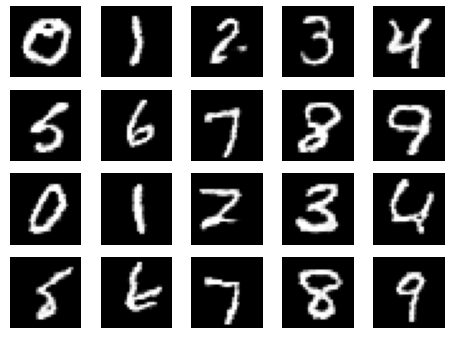

In [9]:
print_digits(4, 5, False)
#print_digit(3)

In [10]:
def weighted_Cov(data: Iterator[Iterator[float]], d: int = 28):
    """Returns the weighted covariance matrix for a digit I.
    data contains lists with information per pixel:
        - Horizontal position of upper left corner
        - Vertical position of upper left corner
        - Grayscale value
    """
    
    # Compute sum of grayscale values
    G = [x[2] for x in data]
    V_1 = sum(G)
    
    # Weighted averages X and Y
    X_bar = 0
    Y_bar = 0
    for pixel in data:
        X_bar += pixel[2] * pixel[0]
        Y_bar += pixel[2] * pixel[1]
    X_bar = X_bar / V_1
    Y_bar = Y_bar / V_1
    
    # Weighted variances
    var_X = 0
    var_Y = 0
    cov_XY = 0
    for pixel in data:
        var_X += pixel[2] * ((pixel[0] - X_bar)**2)
        var_Y += pixel[2] * ((pixel[1] - Y_bar)**2)
        cov_XY += pixel[2] * (pixel[0] - X_bar) * (pixel[1] - Y_bar)
    var_X = var_X / V_1
    var_Y = var_Y / V_1
    cov_XY = cov_XY / V_1
    
    return array([[var_X, cov_XY], [cov_XY, var_Y]])

def find_z_c (axes: Iterator[Iterator[float]], d: int = 28):
    """Returns transformation parameters z and c
    axes: projection matrix, i.e. unit vectors of the axes
    d: dimension (nr of pixels)
    """
    if axes[1][0] > 0 and axes[1][1] > 0: # Principal axis in first quadrant (++)
        c = axes[1][0] * d + axes[1][1] * d
        z = [ axes[0][1] * d, 0 ]
    else: # Principal axis in second quadrant (-+)
        c = axes[0][0] * d + axes[0][1] * d
        z = [ 0, axes[1][0] * d ]
    
    return z, c / d

def inverse_2x2 (A):
    """Returns the inverse of the 2x2 matrix A
    Assumptions: det(A) != 0, i.e. A[0][0] * A[1][1] - A[0][1] * A[1][0] != 0
    """
    
    det = A[0][0] * A[1][1] - A[0][1] * A[1][0]
    
    return [ [ A[1][1]/det, -A[0][1]/det ], [ -A[1][0]/det, A[0][0]/det ] ]

def function_t (A, z, c, p):
    """Computes the transformation map of p (to the new grid)
    A: projection matrix (i.e. unit vectors of axes)
    z: vector for positivity
    c: scaling factor
    """
    
    x = (A[0][0] * p[0] + A[0][1] * p[1]) - z[0]
    y = (A[1][0] * p[0] + A[1][1] * p[1]) - z[1]
    
    return [ x/c, y/c ]

def inverse_t (A, z, c, p):
    """Computes the inverse transformation of p (to the original grid)
    A: projection matrix (i.e. unit vectors of axes)
    z: vector for positivity
    c: scaling factor
    """
    
    A_inv = inverse_2x2(A)
    
    x = (A_inv[0][0] * (c * p[0] + z[0]) + A_inv[0][1] * (c * p[1] + z[1]))
    y = (A_inv[1][0] * (c * p[0] + z[0]) + A_inv[1][1] * (c * p[1] + z[1]))
    
    return [ x, y ]


def principal_axis(cov_Matrix: Iterator[Iterator[float]]):
    "Returns the principal axis (ordered by new horizontal, vertical)."
    
    eigenvalues, eigenvectors = np.linalg.eigh(cov_Matrix)

    if eigenvalues[0] > eigenvalues[1]:
        eigenvectors = [ eigenvectors[1], eigenvectors[0] ]
        eigenvalues = [ eigenvalues[1], eigenvalues[0] ]

    if eigenvectors[0][0] < 0:
        eigenvectors[0] = [ -eigenvectors[0][0], -eigenvectors[0][1] ]
    if eigenvectors[1][1] < 0:
        eigenvectors[1] = [ -eigenvectors[1][0], -eigenvectors[1][1] ]
      
    return eigenvectors


def find_z_c (axes: Iterator[Iterator[float]], d: int = 28):
    """Returns transformation parameters z and c
    axes: projection matrix, i.e. unit vectors of the axes
    d: dimension (nr of pixels)
    """
    if axes[1][0] > 0 and axes[1][1] > 0: # Principal axis in first quadrant (++)
        c = axes[1][0] * d + axes[1][1] * d
        z = [ axes[0][1] * d, 0 ]
    else: # Principal axis in second quadrant (-+)
        c = axes[0][0] * d + axes[0][1] * d
        z = [ 0, axes[1][0] * d ]
    
    return z, c / d

def inverse_2x2 (A):
    """Returns the inverse of the 2x2 matrix A
    Assumptions: det(A) != 0, i.e. A[0][0] * A[1][1] - A[0][1] * A[1][0] != 0
    """
    
    det = A[0][0] * A[1][1] - A[0][1] * A[1][0]
    
    return [ [ A[1][1]/det, -A[0][1]/det ], [ -A[1][0]/det, A[0][0]/det ] ]

def function_t (A, z, c, p):
    """Computes the transformation map of p (to the new grid)
    A: projection matrix (i.e. unit vectors of axes)
    z: vector for positivity
    c: scaling factor
    """
    
    x = (A[0][0] * p[0] + A[0][1] * p[1]) - z[0]
    y = (A[1][0] * p[0] + A[1][1] * p[1]) - z[1]
    
    return [ x/c, y/c ]

def inverse_t (A, z, c, p):
    """Computes the inverse transformation of p (to the original grid)
    A: projection matrix (i.e. unit vectors of axes)
    z: vector for positivity
    c: scaling factor
    """
    
    A_inv = inverse_2x2(A)
    
    x = (A_inv[0][0] * (c * p[0] + z[0]) + A_inv[0][1] * (c * p[1] + z[1]))
    y = (A_inv[1][0] * (c * p[0] + z[0]) + A_inv[1][1] * (c * p[1] + z[1]))
    
    return [ x, y ]

def find_g (data, A, z, c, p, d = 28):
    """Finds the grayscale value of a point p in the new grid
    data: list of arrays (per pixel) containing information about original pixels
            - horizontal position of upper left corner
            - vertical position of upper left corner
            - grayscale value
    A: projection matrix (i.e. unit vectors of axes)
    z: vector for positivity
    c: scaling factor
    d: dimension
    """
    
    q = inverse_t(A, z, c, p)
    
    if 0 <= q[0] <= d and 0 <= q[1] <= d: # Pixel can be transformed to old grid
        column = math.floor(q[0])
        row = d - math.ceil(q[1])
        return data[ row * d + column ][2]
    
    return 0

def rasterize (data, A, z, c, d = 28):
    # Initialize list of grayscale values
    grayscale = []
    m = 5
    
    for i in range(d**2):
        
        g = 0
        # Coordinates of upper left corner of pixel
        x = i % d
        y = d - (i // d) - 1
        
        for k in range(0, m, 1):
            x_sub = x + k/m + 0.5 # x-value of subpixel
            
            for l in range(0, m, 1):
                y_sub = y - l/m - 0.5 # y-value of subpixel
                # Add grayscale value of subpixel
                g += find_g(data, A, z, c, [x_sub, y_sub])
        
        grayscale.append(g / (m**2))
    
    # Transform single list into sublists
    result = []
    for i in range(d):
        result.append(grayscale[ i*d : (i+1)*d ])
    
    return grayscale

def perform_PCA (image, d = 28):
    
    pixel_mids = [ [ (i + 0.5) % d, d - (i // d) - 0.5 ] for i in range(d**2) ]
    
    data = pixel_mids
    grayscale_index = 0
    for i in range(d):
        for j in range(d):
            data[grayscale_index].append(image[i][j])
            grayscale_index += 1
    
    covariance_matrix = weighted_Cov(data)
    axes = principal_axis(covariance_matrix)
    
    z, c = find_z_c(axes)

    return rasterize(data, axes, z, c)

In [11]:
def plot(x, xPCA, y, y_pred):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.suptitle("y: " + str(y) + " pred: " + str(y_pred))
    ax1.axis("off")
    ax2.axis("off")
    ax1.imshow(x, cmap='gray')
    ax2.imshow(xPCA, cmap='gray')
    plt.show()

In [12]:
(image, disresult, n, p, pPCA) = generate_digit(5)
print(image.shape)
imPCA = perform_PCA(image)
plot(image, imPCA, n, n)

(28, 28, 1)


NameError: name 'array' is not defined

In [54]:
amount = 10000
noise = np.random.randn(latent_dim*amount)
gen_input = tf.reshape(noise, (amount, latent_dim))
numbers = np.eye(10)[np.random.randint(10, size=amount)]
gen_input = np.concatenate([gen_input, numbers], axis=1)

xs = generator.predict(gen_input)
ys = discriminator.predict(xs)
realfake = ys[0]
label = ys[1]
preds = predict(xs)
pPCA = predictPCA(xs)


correctACGAN = 0
correctRecog = 0
correctBoth = 0

for (n,x,rf,l,p) in zip(numbers, xs, realfake, label, preds):
    if(n.argmax() == l.argmax()):
        correctACGAN += 1
    if(n.argmax() == p.argmax()):
        correctRecog += 1
    if(n.argmax() == l.argmax() and n.argmax() == p.argmax()):
        correctBoth += 1
    
print(correctACGAN)
print(correctRecog)
print(correctBoth)

9997
9883
9881
